## Data Visualization

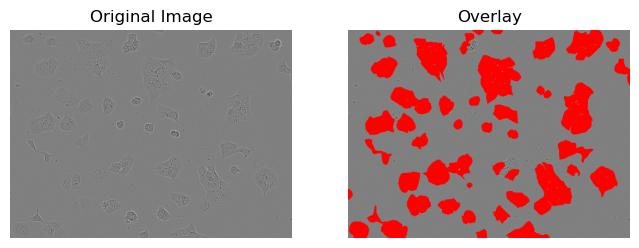

In [ ]:
import cv2
import json
import numpy as np
import os
import random
import matplotlib.pyplot as plt
from pycocotools import mask as coco_mask

# Set paths
IMAGE_DIR = 'images/livecell_train_val_images'
ANNOTATION_FILE = 'livecell_coco_train.json'

# Load COCO annotations
with open(ANNOTATION_FILE, 'r') as f:
    coco_data = json.load(f)

# Select a random image
image_info = random.choice(coco_data["images"])
image_path = os.path.join(IMAGE_DIR, image_info["file_name"])
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # Convert to RGB

# Create an empty mask
mask = np.zeros((image.shape[0], image.shape[1]), dtype=np.uint8)

# Get annotations for the selected image
for annotation in coco_data["annotations"]:
    if annotation["image_id"] == image_info["id"]:
        segmentation = annotation["segmentation"]
        for seg in segmentation:
            pts = np.array(seg, np.int32).reshape(-1, 2)
            cv2.fillPoly(mask, [pts], 255) # Fill mask with white (255)

# Overlay mask on image
overlay = image.copy()
overlay[mask > 0] = (255, 0, 0) # Color cells in red

# Display the image and mask
fig, ax = plt.subplots(1, 2, figsize=(8,16))
ax[0].imshow(image)
ax[0].set_title("Original Image")
ax[0].axis("off")

ax[1].imshow(overlay)
ax[1].set_title("Overlay")
ax[1].axis("off")

plt.show()

In [ ]:
###Checking if the dataset is based on each type of cell
set([img['category_id'] for img in coco_data['annotations']])

{1}

## Dataset Preparartion

In [1]:
import os
import json
import cv2
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2
import matplotlib.pyplot as plt

class LIVECellDataset(Dataset):
    def __init__(self, img_dir, annotation_file,num_images=10,transform=None):
        self.img_dir = img_dir
        self.transform = transform
        self.num_images = num_images
        # Load COCO annotations
        with open(annotation_file, 'r') as f:
            self.data = json.load(f)

        self.images = self.data['images'][:self.num_images]
        self.annotations = self.data['annotations']

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_info = self.images[idx]
        img_path = os.path.join(self.img_dir, img_info["file_name"])
        image = cv2.imread(img_path,cv2.IMREAD_GRAYSCALE)
        # image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)

        # Initialize empty mask
        mask = np.zeros((image.shape[0], image.shape[1]), dtype=np.uint8)

        # Get annotations for this image
        for ann in self.annotations:
            if ann["image_id"] == img_info["id"]:
                for seg in ann["segmentation"]:
                    pts = np.array(seg, np.int32).reshape(-1, 2)
                    cv2.fillPoly(mask, [pts], 1) # Binary mask (1 = cell, 0 = background)

        # Apply transforms
        if self.transform:
            augment = self.transform(image = image,mask = mask)
            image,mask = augment['image'],augment['mask']
            # mask = mask.unsqueeze(0)
        return image, mask

# Define transformations
transform = A.Compose([
    A.Resize(256,256),
    A.Normalize((0.5,), (0.5,)),
    ToTensorV2()
])

def visualize_sample(dataset):
    img, mask = dataset[0]
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(img.squeeze(), cmap="gray")
    ax[0].set_title("Image")
    ax[1].imshow(mask.squeeze(), cmap="gray")
    ax[1].set_title("Mask")
    plt.show()

# visualize_sample(train_dataset)


## Training code

In [ ]:
import argparse
import logging
import os
import random
import sys
import torch
import torch.nn as nn
import torch.nn.functional as F
# import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
from pathlib import Path
from torch import optim
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm
from evaluate import evaluate
from unet import UNet
from utils.dice_score import dice_loss

In [ ]:
def train_model(model,device,epochs: int = 5,batch_size: int = 4,learning_rate: float = 1e-5,
save_checkpoint: bool = True,amp: bool = False,weight_decay: float = 1e-8,momentum: float = 0.999,gradient_clipping: float = 1.0,):
    ### Initializing optimizer and loss function
    optimizer = optim.Adam(model.parameters(),
                              lr=learning_rate, weight_decay=weight_decay, foreach=True)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=5)  # goal: maximize Dice score
    grad_scaler = torch.cuda.amp.GradScaler(enabled=amp)
    criterion = nn.CrossEntropyLoss() if model.n_classes > 1 else nn.BCEWithLogitsLoss()
    global_step = 0
    ### Loading train and validation dataset
    loader_args = dict(batch_size=batch_size)
    train_dataset = LIVECellDataset(img_dir="images/livecell_train_val_images",
                        annotation_file="livecell_coco_train.json",num_images=100,transform=transform)
    train_loader = DataLoader(train_dataset,shuffle=True,**loader_args)
    val_dataset = LIVECellDataset(img_dir="images/livecell_train_val_images",
                        annotation_file="livecell_coco_val.json",num_images=20,transform=transform)
    val_loader = DataLoader(val_dataset,shuffle=False,**loader_args)
    n_train = len(train_loader)
    #Start training
    for epoch in range(1, epochs + 1):
        model.train()
        epoch_loss = 0
        with tqdm(total=n_train, desc=f'Epoch {epoch}/{epochs}', unit='img') as pbar:
            for batch_image,batch_mask in train_loader:
                # print(batch_image.shape, batch_mask.shape,"!!!!!!!!!1")
                images, true_masks = batch_image,batch_mask
                # print(images.shape, true_masks.shape)
                assert images.shape[1] == model.n_channels, \
                    f'Network has been defined with {model.n_channels} input channels, ' \
                    f'but loaded images have {images.shape[1]} channels. Please check that ' \
                    'the images are loaded correctly.'

                images = images.to(device=device, dtype=torch.float32, memory_format=torch.channels_last)
                true_masks = true_masks.to(device=device, dtype=torch.long)

                with torch.autocast(device.type if device.type != 'mps' else 'cpu', enabled=amp):
                    masks_pred = model(images)
                    if model.n_classes == 1:
                        loss = criterion(masks_pred.squeeze(1), true_masks.float())
                        loss += dice_loss(F.sigmoid(masks_pred.squeeze(1)), true_masks.float(), multiclass=False)
                    else:
                        loss = criterion(masks_pred, true_masks)
                        loss += dice_loss(
                            F.softmax(masks_pred, dim=1).float(),
                            F.one_hot(true_masks, model.n_classes).permute(0, 3, 1, 2).float(),
                            multiclass=True
                        )

                optimizer.zero_grad(set_to_none=True)
                grad_scaler.scale(loss).backward()
                grad_scaler.unscale_(optimizer)
                torch.nn.utils.clip_grad_norm_(model.parameters(), gradient_clipping)
                grad_scaler.step(optimizer)
                grad_scaler.update()

                pbar.update(images.shape[0])
                global_step += 1
                epoch_loss += loss.item()
                pbar.set_postfix(**{'loss (batch)': loss.item()})

                # Evaluation round
                division_step = (n_train //  (batch_size))
                if division_step > 0:
                    if global_step % division_step == 0:
                        # print("inside")
                        val_score = evaluate(model, val_loader, device, amp)
                        scheduler.step(val_score)
        if save_checkpoint:
            Path("checkpoint/").mkdir(parents=True, exist_ok=True)
            state_dict = model.state_dict()
            # state_dict['mask_values'] = dataset.mask_values
            torch.save(state_dict, str( 'checkpoint/checkpoint_epoch{}.pth'.format(epoch)))
            print(f'Checkpoint {epoch} saved!')

In [ ]:
torch.cuda.empty_cache()

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = UNet(n_channels=1, n_classes=1, bilinear=False)
model = model.to(memory_format=torch.channels_last)

In [ ]:
model.to(device=device)

train_model(
    model=model,epochs=20,batch_size=2,learning_rate=1e-4,device=device,amp=False)

Epoch 1/20: 100%|██████████| 50/50 [00:17<00:00,  2.94img/s, loss (batch)=0.805]

inside



Validation round: 100%|██████████| 10/10 [00:01<00:00,  6.37batch/s]
Epoch 1/20: 100img [00:35,  2.92img/s, loss (batch)=0.649]                      

inside



Validation round: 100%|██████████| 10/10 [00:01<00:00,  6.11batch/s]
Epoch 1/20: 100img [00:37,  2.67img/s, loss (batch)=0.649]          


Checkpoint 1 saved!


Epoch 2/20: 100%|██████████| 50/50 [00:17<00:00,  2.94img/s, loss (batch)=0.639]

inside



Validation round: 100%|██████████| 10/10 [00:01<00:00,  5.92batch/s]
Epoch 2/20: 100img [00:35,  2.93img/s, loss (batch)=0.503]                      

inside



Validation round: 100%|██████████| 10/10 [00:01<00:00,  5.99batch/s]
Epoch 2/20: 100img [00:37,  2.67img/s, loss (batch)=0.503]          


Checkpoint 2 saved!


Epoch 3/20: 100%|██████████| 50/50 [00:17<00:00,  2.94img/s, loss (batch)=0.612]

inside



Validation round: 100%|██████████| 10/10 [00:01<00:00,  6.47batch/s]
Epoch 3/20: 100img [00:35,  2.94img/s, loss (batch)=0.446]                      

inside



Validation round: 100%|██████████| 10/10 [00:01<00:00,  6.11batch/s]
Epoch 3/20: 100img [00:37,  2.68img/s, loss (batch)=0.446]          


Checkpoint 3 saved!


Epoch 4/20: 100%|██████████| 50/50 [00:17<00:00,  2.93img/s, loss (batch)=0.422]

inside



Validation round: 100%|██████████| 10/10 [00:01<00:00,  6.65batch/s]
Epoch 4/20: 100img [00:35,  2.92img/s, loss (batch)=0.581]                      

inside



Validation round: 100%|██████████| 10/10 [00:01<00:00,  6.54batch/s]
Epoch 4/20: 100img [00:37,  2.69img/s, loss (batch)=0.581]          


Checkpoint 4 saved!


Epoch 5/20: 100%|██████████| 50/50 [00:17<00:00,  2.94img/s, loss (batch)=0.418]

inside



Validation round: 100%|██████████| 10/10 [00:01<00:00,  6.55batch/s]
Epoch 5/20: 100img [00:35,  2.93img/s, loss (batch)=0.433]                      

inside



Validation round: 100%|██████████| 10/10 [00:01<00:00,  6.55batch/s]
Epoch 5/20: 100img [00:37,  2.69img/s, loss (batch)=0.433]          


Checkpoint 5 saved!


Epoch 6/20: 100%|██████████| 50/50 [00:17<00:00,  2.91img/s, loss (batch)=0.535]

inside



Validation round: 100%|██████████| 10/10 [00:01<00:00,  6.56batch/s]
Epoch 6/20: 100img [00:35,  2.92img/s, loss (batch)=0.439]                      

inside



Validation round: 100%|██████████| 10/10 [00:01<00:00,  6.60batch/s]
Epoch 6/20: 100img [00:37,  2.68img/s, loss (batch)=0.439]          


Checkpoint 6 saved!


Epoch 7/20: 100%|██████████| 50/50 [00:17<00:00,  2.93img/s, loss (batch)=0.351]

inside



Validation round: 100%|██████████| 10/10 [00:01<00:00,  6.54batch/s]
Epoch 7/20: 100img [00:35,  2.93img/s, loss (batch)=0.497]                      

inside



Validation round: 100%|██████████| 10/10 [00:01<00:00,  6.48batch/s]
Epoch 7/20: 100img [00:37,  2.69img/s, loss (batch)=0.497]          


Checkpoint 7 saved!


Epoch 8/20: 100%|██████████| 50/50 [00:17<00:00,  2.93img/s, loss (batch)=0.459]

inside



Validation round: 100%|██████████| 10/10 [00:01<00:00,  6.60batch/s]
Epoch 8/20: 100img [00:35,  2.94img/s, loss (batch)=0.411]                      

inside



Validation round: 100%|██████████| 10/10 [00:01<00:00,  6.60batch/s]
Epoch 8/20: 100img [00:37,  2.69img/s, loss (batch)=0.411]          


Checkpoint 8 saved!


Epoch 9/20: 100%|██████████| 50/50 [00:17<00:00,  2.93img/s, loss (batch)=0.361]

inside



Validation round: 100%|██████████| 10/10 [00:01<00:00,  6.54batch/s]
Epoch 9/20: 100img [00:35,  2.93img/s, loss (batch)=0.462]                      

inside



Validation round: 100%|██████████| 10/10 [00:01<00:00,  6.53batch/s]
Epoch 9/20: 100img [00:37,  2.69img/s, loss (batch)=0.462]          


Checkpoint 9 saved!


Epoch 10/20: 100%|██████████| 50/50 [00:17<00:00,  2.93img/s, loss (batch)=0.351]

inside



Validation round: 100%|██████████| 10/10 [00:01<00:00,  6.06batch/s]
Epoch 10/20: 100img [00:35,  2.94img/s, loss (batch)=0.332]                      

inside



Validation round: 100%|██████████| 10/10 [00:01<00:00,  5.90batch/s]
Epoch 10/20: 100img [00:37,  2.67img/s, loss (batch)=0.332]         


Checkpoint 10 saved!


Epoch 11/20: 100%|██████████| 50/50 [00:17<00:00,  2.94img/s, loss (batch)=0.333]

inside



Validation round: 100%|██████████| 10/10 [00:01<00:00,  5.92batch/s]
Epoch 11/20: 100img [00:35,  2.94img/s, loss (batch)=0.429]                      

inside



Validation round: 100%|██████████| 10/10 [00:01<00:00,  6.01batch/s]
Epoch 11/20: 100img [00:37,  2.67img/s, loss (batch)=0.429]         


Checkpoint 11 saved!


Epoch 12/20: 100%|██████████| 50/50 [00:17<00:00,  2.90img/s, loss (batch)=0.42] 

inside



Validation round: 100%|██████████| 10/10 [00:01<00:00,  5.88batch/s]
Epoch 12/20: 100img [00:35,  2.92img/s, loss (batch)=0.318]                     

inside



Validation round: 100%|██████████| 10/10 [00:01<00:00,  5.92batch/s]
Epoch 12/20: 100img [00:37,  2.66img/s, loss (batch)=0.318]         


Checkpoint 12 saved!


Epoch 13/20: 100%|██████████| 50/50 [00:17<00:00,  2.92img/s, loss (batch)=0.417]

inside



Validation round: 100%|██████████| 10/10 [00:01<00:00,  5.97batch/s]
Epoch 13/20: 100img [00:35,  2.93img/s, loss (batch)=0.567]                      

inside



Validation round: 100%|██████████| 10/10 [00:01<00:00,  5.88batch/s]
Epoch 13/20: 100img [00:37,  2.66img/s, loss (batch)=0.567]         


Checkpoint 13 saved!


Epoch 14/20: 100%|██████████| 50/50 [00:17<00:00,  2.93img/s, loss (batch)=0.318]

inside



Validation round: 100%|██████████| 10/10 [00:01<00:00,  5.96batch/s]
Epoch 14/20: 100img [00:35,  2.93img/s, loss (batch)=0.296]                      

inside



Validation round: 100%|██████████| 10/10 [00:01<00:00,  5.90batch/s]
Epoch 14/20: 100img [00:37,  2.67img/s, loss (batch)=0.296]         


Checkpoint 14 saved!


Epoch 15/20: 100%|██████████| 50/50 [00:17<00:00,  2.93img/s, loss (batch)=0.257]

inside



Validation round: 100%|██████████| 10/10 [00:01<00:00,  5.91batch/s]
Epoch 15/20: 100img [00:35,  2.93img/s, loss (batch)=0.252]                      

inside



Validation round: 100%|██████████| 10/10 [00:01<00:00,  6.01batch/s]
Epoch 15/20: 100img [00:37,  2.67img/s, loss (batch)=0.252]         


Checkpoint 15 saved!


Epoch 16/20: 100%|██████████| 50/50 [00:17<00:00,  2.93img/s, loss (batch)=0.411]

inside



Validation round: 100%|██████████| 10/10 [00:01<00:00,  6.05batch/s]
Epoch 16/20: 100img [00:35,  2.89img/s, loss (batch)=0.222]                      

inside



Validation round: 100%|██████████| 10/10 [00:01<00:00,  5.89batch/s]
Epoch 16/20: 100img [00:37,  2.66img/s, loss (batch)=0.222]         


Checkpoint 16 saved!


Epoch 17/20: 100%|██████████| 50/50 [00:17<00:00,  2.94img/s, loss (batch)=0.218]

inside



Validation round: 100%|██████████| 10/10 [00:01<00:00,  5.90batch/s]
Epoch 17/20: 100img [00:35,  2.94img/s, loss (batch)=0.234]                      

inside



Validation round: 100%|██████████| 10/10 [00:01<00:00,  5.88batch/s]
Epoch 17/20: 100img [00:37,  2.67img/s, loss (batch)=0.234]         


Checkpoint 17 saved!


Epoch 18/20: 100%|██████████| 50/50 [00:17<00:00,  2.94img/s, loss (batch)=0.209]

inside



Validation round: 100%|██████████| 10/10 [00:01<00:00,  6.05batch/s]
Epoch 18/20: 100img [00:35,  2.93img/s, loss (batch)=0.224]                      

inside



Validation round: 100%|██████████| 10/10 [00:01<00:00,  5.94batch/s]
Epoch 18/20: 100img [00:37,  2.67img/s, loss (batch)=0.224]         


Checkpoint 18 saved!


Epoch 19/20: 100%|██████████| 50/50 [00:17<00:00,  2.92img/s, loss (batch)=0.262]

inside



Validation round: 100%|██████████| 10/10 [00:01<00:00,  5.90batch/s]
Epoch 19/20: 100img [00:35,  2.93img/s, loss (batch)=0.295]                      

inside



Validation round: 100%|██████████| 10/10 [00:01<00:00,  6.07batch/s]
Epoch 19/20: 100img [00:37,  2.67img/s, loss (batch)=0.295]         


Checkpoint 19 saved!


Epoch 20/20: 100%|██████████| 50/50 [00:17<00:00,  2.92img/s, loss (batch)=0.263]

inside



Validation round: 100%|██████████| 10/10 [00:01<00:00,  6.12batch/s]
Epoch 20/20: 100img [00:35,  2.91img/s, loss (batch)=0.222]                      

inside



Validation round: 100%|██████████| 10/10 [00:01<00:00,  5.96batch/s]
Epoch 20/20: 100img [00:37,  2.65img/s, loss (batch)=0.222]         


Checkpoint 20 saved!


## Inferencing

In [7]:
def overlay_mask(image, mask, alpha=0.5):
    """
    Overlay predicted mask on the test image.
    - `alpha` controls transparency (0 = only image, 1 = only mask).
    """
    image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
    color_mask = np.zeros_like(image)
    color_mask[:, :, 2] = mask  # Red channel for mask visualization

    overlay = cv2.addWeighted(image, 1, color_mask, alpha, 0)
    return overlay

In [11]:
import os
import cv2
import torch
import numpy as np
import albumentations as A
from albumentations.pytorch import ToTensorV2
from unet import UNet  # Import U-Net from the GitHub repo

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load Trained Model
model = UNet(n_channels=1, n_classes=1).to(device)
model.load_state_dict(torch.load("checkpoint/checkpoint_epoch19.pth", map_location=device))
model.eval()

# Transformations (same as training)
transform = A.Compose([
    A.Resize(256, 256),
    A.Normalize(mean=[0.5], std=[0.5]),
    ToTensorV2(),
])

# ---------------------------
# 🔹 Inference Function
# ---------------------------
def predict(image_path, threshold=0.5):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    # image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)  # Convert to 3 channels

    # Apply Transform
    transformed = transform(image=image)
    image_tensor = transformed["image"].unsqueeze(0).to(device)

    # Model Prediction
    with torch.no_grad():
        output = model(image_tensor)
        output = torch.sigmoid(output)  # Convert logits to probabilities
        output = output.squeeze().cpu().numpy()

    # Convert Probabilities to Binary Mask
    mask = (output > threshold).astype(np.uint8) * 255
    mask = cv2.resize(mask,(image.shape[1],image.shape[0]))
    overlay_image = overlay_mask(image,mask,alpha = 0.5)
    # cv2.imwrite("overlay.png",overlay_image)
    return overlay_image

# ---------------------------
# 🔹 Run Inference on a Test Image
# ---------------------------
test_image = "/content/A172_Phase_C7_1_00d00h00m_1.tif"
predicted_mask = predict(test_image)

# Save Prediction
img_name = test_image.split("/")[-1].replace(".tif",".png")
cv2.imwrite(f"overlay_{img_name}", predicted_mask)
print(f"Prediction saved as overlay_{img_name}")

<ipython-input-11-ddaa1f945efb>:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("checkpoint/checkpoint_epoch19.pth", map_location=device))

Prediction saved as A172_Phase_C7_1_00d00h00m_1.png


## Evaluation

In [15]:
import torch
import numpy as np
import cv2
from sklearn.metrics import average_precision_score

# ---------------------------
# 🔹 IoU Calculation for Mask Annotations
# ---------------------------
def calculate_iou(pred_mask, gt_mask):
    """
    param:
        pred_mask-The ouput from unet model
        gt_mask- the actual mask of an image
    return Intersection over Union (IoU) between predicted and ground truth binary masks.
    """
    intersection = np.logical_and(pred_mask, gt_mask).sum()
    union = np.logical_or(pred_mask, gt_mask).sum()
    iou = intersection / (union + 1e-6)
    return iou
def evaluate_map(model, test_loader, iou_threshold=0.5):
    model.eval()
    iou_scores = []
    ap_scores = []

    with torch.no_grad():
        for images, masks in test_loader:
            images, masks = images.to(device), masks.to(device)

            outputs = model(images)
            outputs = torch.sigmoid(outputs).cpu().numpy()
            masks = masks.cpu().numpy()

            for pred_mask, gt_mask in zip(outputs, masks):
                pred_mask = (pred_mask > 0.5).astype(np.uint8)
                gt_mask = (gt_mask > 0.5).astype(np.uint8)

                # Compute IoU
                iou = calculate_iou(pred_mask, gt_mask)
                iou_scores.append(iou)

                # Compute Average Precision
                ap = average_precision_score(gt_mask.flatten(), pred_mask.flatten())
                ap_scores.append(ap)

    mean_iou = np.mean(iou_scores)
    mean_ap = np.mean(ap_scores)

    print(f"Mean IoU: {mean_iou:.4f}")
    print(f"mAP: {mean_ap:.4f}")
    return mean_ap
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_test = UNet(n_channels=1, n_classes=1).to(device)
model_test.load_state_dict(torch.load("/content/checkpoint/checkpoint_epoch19.pth", map_location=device))
loader_args = dict(batch_size=2,num_workers=2)
test_dataset = LIVECellDataset(img_dir="/content/images/livecell_test_images",
                               annotation_file="/content/livecell_coco_test.json",num_images=1500,transform=transform)
test_loader = DataLoader(test_dataset,shuffle=False,**loader_args)
evaluate_map(model_test, test_loader)

<ipython-input-15-d0df8e616eca>:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_test.load_state_dict(torch.load("/content/checkpoint/checkpoint_epoch19.pth", map_loc

Mean IoU: 0.7861
mAP: 0.8349


0.8349011497752689

## Remark
- Due to unavaibality of computing resources
    - Model is trained with 100 images and 20 validation images (80:20 ratio)
    - Accuracy can be improved by taking total dataset for training